Can questions define a Dataset?
===============================
### Reference implemetation



This notebook contains the steps for accuretly reproducing the paper. It's not intended to be a complete guide to the methods applied. If you're interested in just exploring the technique of applying it to smaller dataset, we suggest you to read our paper or start with the QuestionGenerationTutorial notebook.

# Environment

Checks the environment where we're running. We don't suggest proceeding without a nice GPU with at least 4Gb of RAM.

In [1]:
import os
from datetime import datetime, timedelta

import torch
import pandas as pd
from tqdm.notebook import tqdm

# Create and register a new `tqdm` instance with `pandas`
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

os.cpu_count(), torch.cuda.get_device_name() if device == "cuda" else None

/home/gsurita/.local/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


(12, 'GeForce RTX 2060')

# Downloading

This section downloads the pinned version of the CORD-19 dataset.

In [1]:
!wget https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/historical_releases/cord-19_2020-08-26.tar.gz

--2020-08-27 00:24:16--  https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/historical_releases/cord-19_2020-08-26.tar.gz
Resolving ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com (ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com)... 52.218.240.185
Connecting to ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com (ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com)|52.218.240.185|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4312499999 (4,0G) [binary/octet-stream]
Saving to: ‘cord-19_2020-08-26.tar.gz’

cord-19_2020-08-26. 100%[===================>]   4,02G   153KB/s    in 4h 39m  

2020-08-27 05:04:13 (251 KB/s) - ‘cord-19_2020-08-26.tar.gz’ saved [4312499999/4312499999]



In [3]:
! tar -xf cord-19_2020-08-26.tar.gz
! tar -xf 2020-08-26/document_parses.tar.gz

^C


# Preprocessing

This section:

1. Reads the dataset into memory.
2. Apply preprocessing to remove content that's not natural language such as websites, email addresses, references, section names, etc.
3. Join the textual data to article metadata.
4. Select only papers related to COVID-19. Apply a simple regex filter on an attempt to remove related diseases.
5. Saves the result of this step into a "covid.csv" file for further steps.

In [3]:
import re
import json
import itertools
from pathlib import Path

import pandas as pd

path = Path("./document_parses/pdf_json")
files = list(path.iterdir())


print("Files:", len(files))


def preprocessing(text):
    # remove mail
    text = re.sub(r'[a-z0-9._%+-]+@[a-z0-9.-]+\.[a-z]{2,}', 'MAIL', text)
    # remove doi
    text = re.sub(r'https\:\/\/doi\.org[^\s]+', 'DOI', text)
    # remove https
    text = re.sub(r'(\()?\s?http(s)?\:\/\/[^\)]+(\))?', '\g<1>LINK\g<3>', text)
    # remove single characters repeated at least 3 times for spacing error (e.g. s u m m a r y)
    text = re.sub(r'(\w\s+){3,}', ' ', text)
    # replace tags (e.g. [3] [4] [5]) with whitespace
    text = re.sub(r'(\[\d+\]\,?\s?){3,}(\.|\,)?', ' \g<2>', text)
    # replace tags (e.g. [3, 4, 5]) with whitespace
    text = re.sub(r'\[[\d\,\s]+\]', ' ',text)
     # replace tags (e.g. (NUM1) repeated at least 3 times with whitespace
    text = re.sub(r'(\(\d+\)\s){3,}', ' ',text)
    # replace '1.3' with '1,3' (we need it for split later)
    text = re.sub(r'(\d+)\.(\d+)', '\g<1>,\g<2>', text)
    # remove all full stops as abbreviations (e.g. i.e. cit. and so on)
    text = re.sub(r'\.(\s)?([^A-Z\s])', ' \g<1>\g<2>', text)
    # correctly spacing the tokens
    text = re.sub(r' {2,}', ' ', text)
    text = re.sub(r'\.{2,}', '.', text)
    # return lowercase text
    return text.lower()


def read_paper(p):
    """Read one paper to the dataframe."""
    
    with open(p) as f:    
        data = json.load(f)
        id = data["paper_id"]
        title = data["metadata"]["title"]
        text_blocks = (preprocessing(p["text"]) for p in data["abstract"] + data["body_text"])

    return {"text": " ".join(text_blocks), "title": title, "paper_id": id} 


paper_df = pd.DataFrame(read_paper(p) for p in tqdm(files))

Files: 101688


In [4]:
# Merges the metadata with the actual dataset.

metadata = pd.read_csv("2020-08-26/metadata.csv")

merged_df = pd.merge(metadata, paper_df, left_on="sha", right_on="paper_id")
merged_df["publish_time"] = pd.to_datetime(merged_df["publish_time"])

/home/gsurita/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
# FIlter only papers related to COVID-19.
# https://www.kaggle.com/matteomuffo/a-fine-grained-covid-19-question-answering-engine

covid_terms =['covid', 'coronavirus disease 19', 'sars cov 2', '2019 ncov', '2019ncov', '2019 n cov', '2019n cov',
              'ncov 2019', 'n cov 2019', 'coronavirus 2019', 'wuhan pneumonia', 'wuhan virus', 'wuhan coronavirus',
              'coronavirus 2', 'covid-19', 'SARS-CoV-2', '2019-nCov']
covid_terms = [elem.lower() for elem in covid_terms]
covid_terms = re.compile('|'.join(covid_terms))

merged_df["is_covid"] = (
    merged_df.text.progress_apply(lambda r: bool(covid_terms.search(r)))
    & (merged_df.publish_time > datetime(2019, 10, 1))
)

covid_df = merged_df[merged_df.is_covid]

In [6]:
# Save preprocessing results.
covid_df.to_csv("./covid.csv")

# Question Generation

This section does most of the  heavy work. This is expected to take about 48h in a RTX 2060 GPU.

Here we basically:

1. Download the pretrained question generation model.
2. Define generation funcions.
3. Apply the generation pipeline to the full dataset.

In [16]:
covid_df = pd.read_csv("./covid.csv")

/home/gsurita/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [38]:
! wget -nc https://storage.googleapis.com/doctttttquery_git/t5-base.zip
! unzip -o t5-base.zip

--2020-08-27 20:44:43--  https://storage.googleapis.com/doctttttquery_git/t5-large.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 2800:3f0:4001:80a::2010, 2800:3f0:4001:80b::2010, 2800:3f0:4001:816::2010, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2800:3f0:4001:80a::2010|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1177655790 (1,1G) [application/zip]
Saving to: ‘t5-large.zip’

t5-large.zip        100%[===================>]   1,10G  9,78MB/s    in 2m 0s   

2020-08-27 20:46:44 (9,37 MB/s) - ‘t5-large.zip’ saved [1177655790/1177655790]

Archive:  t5-large.zip
  inflating: model.ckpt-1004700.data-00000-of-00002  
  inflating: model.ckpt-1004700.data-00001-of-00002  
  inflating: model.ckpt-1004700.index  
  inflating: model.ckpt-1004700.meta  


In [6]:
import torch
from transformers import T5Config, T5Tokenizer, T5ForConditionalGeneration

# Instantiate and load the QG model to the GPU. 
qg_tokenizer = T5Tokenizer.from_pretrained('t5-base')
qg_config = T5Config.from_pretrained('t5-base')
qg_model = T5ForConditionalGeneration.from_pretrained('model.ckpt-1004000', from_tf=True, config=qg_config)

qg_model.to(device)

True

1

In [12]:
import nltk
from nltk.tokenize import sent_tokenize


nltk.download('punkt')


def generate_questions_doc_t5_query(context, q=1):
    """
    Generate q questions for the provided text context.
    """
    doc_text = f"{context} </s>"

    with torch.no_grad():
        # TODO: We can probably batch this.
        input_ids = qg_tokenizer.encode(doc_text, return_tensors='pt').to(device)
        outputs = qg_model.generate(
            input_ids=input_ids,
            max_length=64,
            do_sample=False,
            num_return_sequences=q,
        )

    return [
        qg_tokenizer.decode(output)
        for output in outputs
    ]


def batch_doc(text, span=10, stride=5):
    """
    Convert a document into a list of chunks with 10 span of 10 and stride of 5 sentences.
    """
    sentences = sent_tokenize(text)
    chunks = [" ".join(sentences[i:i+span]) for i in range(0, len(sentences), stride)]

    return chunks

[nltk_data] Downloading package punkt to /home/gsurita/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [13]:
# Compute the batches for all dataset.
batches = [batch_doc(text) for text in tqdm(covid_df.text)]

In [14]:
import numpy as np

# Here we perform some simple size checks. and remove the 1% outliers. 
# This step is required to avoid ill parsed documents to take very long on the generation step.

max_batch, max_block = (
    np.percentile([len(b) for b in batches], 99), 
    np.percentile([len(t) for b in batches for t in b], 99)
)

max_batch, max_block

(41.0, 2276.0)

In [18]:
# Starting checkpoint.
chkp = 0  

# Frequency to generate a checkpoint (in documents).
chkp_freq = 1000

# Version of the generation (change this number to prevent overriting prior generations).
version = 1

if not chkp:
    question_df = covid_df.copy()
    question_df["questions"] = ''
else:
    question_df = pd.read_csv(f"./cord_questions/covid_questions.{version}.{chkp}.csv", low_memory=False)

def run_generation_step(idx, batch):
    qs = [generate_questions_doc_t5_query(t[:max_block]) for t in batch[:max_batch]]
    qs_text = ". ".join([q for doc in qs for q in doc])
    question_df.questions.iloc[idx] = qs_text
    
    if idx and not idx % 1000:
        question_df.to_csv(f"./cord_questions/covid_questions.{version}.{idx}.csv")
    
    return qs


questions = [
    run_generation_step(idx, batch)
    for idx, batch in zip(range(chkp, len(covid_df)), tqdm(batches[chkp:]))
]


question_df.to_csv(f"./cord_questions/covid_questions.{version}.{len(covid_df)}.csv")

Token indices sequence length is longer than the specified maximum sequence length for this model (514 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (599 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (627 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (545 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (528 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (524 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (592 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (563 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (540 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (613 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

# Qualitative Experiments

In [10]:
import pandas as pd
 
question_df = pd.read_csv("./cord_questions/covid_questions.1.41526.csv", low_memory=False)
question_df = question_df[~question_df.questions.isna()]
question_df["publish_time_dt"] = pd.to_datetime(question_df.publish_time)

In [11]:
question_df

Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1  Unnamed: 0.1.1.1  cord_uid  \
0               0             0               0              4001  wvx6q999   
1               1             1               1              4068  any3ztrm   
2               2             2               2              4310  54glvasa   
3               3             3               3              4780  av1gk318   
4               4             4               4              5187  8cehlsa4   
...           ...           ...             ...               ...       ...   
41521       41521         41521           41521             88657  2kbtuc0t   
41522       41522         41522           41522             88658  7k0oym5i   
41523       41523         41523           41523             88661  ehyuesvf   
41524       41524         41524           41524             88662  zc2u3hqv   
41525       41525         41525           41525             88667  44114vqr   

                                            sha                source_x  \
0      d958168df85240e544a918d843a14e887dc41d2b                     PMC   
1      8b637fe79618c0664d68352accf9eec80f7fe18e                     PMC   
2      601e6ac1ad98e359dc021e8896a1a604331ca774                     PMC   
3      40cc562681d4a838bfe5c246086646ab29563a34                     PMC   
4      1a92bf7defda97e4859f8b4869012db33da973a5                     PMC   
...                                         ...                     ...   
41521  1b7a0ed8e9271b6b25b12d56c58fe6b711f98fcb           Elsevier; PMC   
41522  b2211d795ab65607805c26a26c30e8f767860489            Medline; PMC   
41523  cd7451890932d6733c09ae3be36c1d2285e01a71  Elsevier; Medline; PMC   
41524  37952acbcd54bde429434e2e642b47a3f3d151c5            Medline; PMC   
41525  7d273b6786ff09629d5aaf2f3f165d3a074f98c3  Elsevier; Medline; PMC   

                                                 title_x  \
0      Note from the editors: novel coronavirus (2019...   
1      Neurally adjusted ventilatory assist vs. press...   
2      Empfehlungen zur intensivmedizinischen Therapi...   
3      Abstracts from the 39th Congress of the Sociét...   
4      Multiday maintenance of extracorporeal lungs u...   
...                                                  ...   
41521  The effect of collaboration and IT competency ...   
41522  Rapid Uptake of Home-Based HIV Self-testing Du...   
41523  The temperature and regional climate effects o...   
41524  School closure, COVID‐19 and lunch programme: ...   
41525  Cardiac involvement in recovered COVID-19 pati...   

                                          doi       pmcid  ...  \
0      10.2807/1560-7917.es.2020.25.3.2001231  PMC6988271  ...   
1                   10.1186/s13613-020-0638-0  PMC7010869  ...   
2                  10.1007/s00063-020-00674-3  PMC7080004  ...   
3                  10.1007/s00345-019-02955-9  PMC7088284  ...   
4                 10.1016/j.jtcvs.2019.09.121  PMC7094131  ...   
...                                       ...         ...  ...   
41521              10.1016/j.eiar.2020.106433  PMC7336126  ...   
41522              10.1007/s10461-020-02959-2  PMC7320648  ...   
41523         10.1016/j.scitotenv.2020.139560  PMC7236730  ...   
41524                       10.1111/jpc.15018  PMC7361388  ...   
41525              10.1016/j.jcmg.2020.05.004  PMC7214335  ...   

                                          pdf_json_files  \
0      document_parses/pdf_json/d958168df85240e544a91...   
1      document_parses/pdf_json/8b637fe79618c0664d683...   
2      document_parses/pdf_json/601e6ac1ad98e359dc021...   
3      document_parses/pdf_json/40cc562681d4a838bfe5c...   
4      document_parses/pdf_json/1a92bf7defda97e4859f8...   
...                                                  ...   
41521  document_parses/pdf_json/1b7a0ed8e9271b6b25b12...   
41522  document_parses/pdf_json/b2211d795ab65607805c2...   
41523  document_parses/pdf_json/cd7451890932d6733c09a...   
41524  document_parses/pdf_json/37952acbcd5

In [12]:
from datetime import datetime

# Postprocessing ignores.
ignore = {
    "preprint",
    "cc-by", 
    "copyright",
    "can you reuse a file",
    "reserved",
    "medrxiv",
}

question_df = pd.DataFrame(
    dict(
        counts=1,
        date=row.publish_time_dt,
        question=q, # .replace("-", " "),
        cord_uid=row.cord_uid,
    )
    for row in question_df.itertuples()
    for q in row.questions.split(". ")
    if all(i not in q for i in ignore)
)

question_to_date = question_df[question_df.date < datetime(2020, 8, 27)]


In [6]:
# Top 15.

question_df.groupby("question").sum().counts.sort_values(ascending=False).head(15).reset_index()

question  counts
0           what is the treatment for covid    3214
1                          what is covid 19    2622
2                          what is covid-19    1797
3                          what is sars cov    1717
4                 what is the risk of covid    1498
5               what is the impact of covid    1474
6                             what is covid    1328
7           what is the prevalence of covid    1103
8                          what is sars-cov    1005
9       what is the mortality rate of covid     955
10  what is the incubation period for covid     942
11                    what is the sir model     916
12                       what is sars-cov-2     842
13           what is the incidence of covid     810
14                what is social distancing     687

In [13]:
# Unique questions.

question_df.groupby("question").sum().counts.sort_values(ascending=False).count()

470749

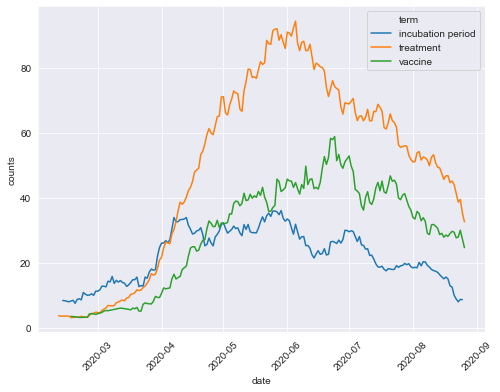

In [6]:
# Questions over time.

import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_style("darkgrid")
matplotlib.rcParams['figure.figsize'] = 8, 6


question_date_group = question_to_date \
    .groupby([question_to_date.date, question_to_date.question]) \
    .sum() \
    .reset_index()
    

def seq_format(qs):
    
    def to_group(q):
        group = question_date_group[question_date_group.question.str.contains(q)].groupby("date").sum().rolling(15).mean().reset_index()
        group["term"] = q
        return group
    
    return pd.concat([
        to_group(q)
        for q in qs
    ])


def plot_terms(ts):

    ax = sns.lineplot(
        x="date",
        y="counts",
        hue="term",
        data=seq_format(ts)
    )

    ax.tick_params(axis='x', rotation=45)
    return ax

plot_terms(["incubation period", "treatment", "vaccine"])
plt.savefig("results/treatments.pdf")

In [14]:
# Save top 1000k to CSV
question_df.groupby("question").sum().counts.sort_values(ascending=False).head(10000).reset_index().to_csv("./results/top_10k.csv")

# Quantitative Experiments

In [15]:
!wget https://raw.githubusercontent.com/castorini/pygaggle/master/data/kaggle-lit-review-0.2.json

--2020-09-08 23:10:39--  https://raw.githubusercontent.com/castorini/pygaggle/master/data/kaggle-lit-review-0.2.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.92.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.92.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51438 (50K) [text/plain]
Saving to: ‘kaggle-lit-review-0.2.json.1’

kaggle-lit-review-0 100%[===================>]  50,23K  --.-KB/s    in 0,08s   

2020-09-08 23:10:39 (642 KB/s) - ‘kaggle-lit-review-0.2.json.1’ saved [51438/51438]



In [16]:
import json

covid_qa = json.load(open("kaggle-lit-review-0.2.json"))

covid_qa_questions = [
    subcat["kq_name"]
    for cat in covid_qa["categories"]
    for subcat in cat["sub_categories"]
]

covid_qa_articles = [
    [ans["id"] for ans in subcat["answers"]]
    for cat in covid_qa["categories"]
    for subcat in cat["sub_categories"]
]

len(covid_qa_questions)

27

In [51]:
most_frequent = question_df.groupby("question").sum().counts.sort_values(ascending=False).reset_index()
most_frequent = most_frequent[most_frequent.counts >= 3]

In [19]:
from tqdm.notebook import tqdm
from bert_score import score, plot_example

most_frequent_list = most_frequent.question.tolist()
results = []


for ref in tqdm(covid_qa_questions):
    candidates = most_frequent_list
    references = [ref for _ in candidates]

    P, R, F1 = score(references, candidates, model_type="scibert-scivocab-uncased", lang="en")

    top_3_candidates = sorted(((p, s) for p, s in zip(F1, candidates)), reverse=True)[:3]

    for i, (p, s) in enumerate(top_3_candidates):
        results.append({
            "reference": ref,
            "candidate": s,
            "index": i + 1
        })
    
    
results_df = pd.DataFrame(results)
results_df.to_csv("results/aggregated_experiment.csv")

results_df

reference  \
0                     Incubation period of the virus   
1                     Incubation period of the virus   
2                     Incubation period of the virus   
3       Length of viral shedding after illness onset   
4       Length of viral shedding after illness onset   
..                                               ...   
76   HR for death in COVID-19 patients with diabetes   
77   HR for death in COVID-19 patients with diabetes   
78  AHR for death in COVID-19 patients with diabetes   
79  AHR for death in COVID-19 patients with diabetes   
80  AHR for death in COVID-19 patients with diabetes   

                           candidate  index  
0   incubation period of coronavirus      1  
1      incubation period for a virus      2  
2    incubation period for influenza      3  
3         duration of viral shedding      1  
4     duration of viral rna shedding      2  
..                               ...    ...  
76          causes of death in covid      2  
77     covid 19 symptoms in children      3  
78          causes of death in covid      1  
79             age of death in covid      2  
80     covid 19 symptoms in children      3  

[81 rows x 3 columns]

In [20]:
results_doc = []

for ref, docs in zip(tqdm(covid_qa_questions), covid_qa_articles):
    
    for doc in docs:

        doc_matches = question_df[question_df.cord_uid == doc]
        
        # Couldn't find the doc.
        if not len(doc_matches):
            continue
                    
        candidates = doc_matches.question.iloc[0].split(". ")
        P, R, F1 = score([ref for _ in candidates], candidates, model_type="scibert-scivocab-uncased", lang="en")
        for i, (_, s) in enumerate(sorted(((p, s) for p, s in zip(F1, candidates)), reverse=True)[:3]):
            results_doc.append({
                "reference": ref,
                "doc": doc,
                "candidate": s,
                "index": i,
            })

            
results_doc_df = pd.DataFrame(results_doc)
results_doc_df.to_csv("results/per_document_experiment.csv")

results_doc_df

reference       doc  \
0                       Incubation period of the virus  wuclekt6   
1                       Incubation period of the virus  e3t1f0rt   
2                       Incubation period of the virus  ragcpbl6   
3                       Incubation period of the virus  n0uwy77g   
4                       Incubation period of the virus  x23ej29m   
..                                                 ...       ...   
132  RR for severe infection in COVID-19 patients w...  u6uqroi0   
133  RR for severe infection in COVID-19 patients w...  4mnmaky6   
134    HR for death in COVID-19 patients with diabetes  nrdiqees   
135    HR for death in COVID-19 patients with diabetes  ol21k1a8   
136   AHR for death in COVID-19 patients with diabetes  skknfc6h   

                                             candidate  index  
0             what is the average blood test for covid      0  
1                          incubation period for covid      0  
2              where does the covid epidemic originate      0  
3                duration of hospitalization for covid      0  
4                                     what is covid 19      0  
..                                                 ...    ...  
132  what is the association between ards and diabetes      0  
133           what is the risk factor for severe covid      0  
134      what is the risk of preexisting comorbidities      0  
135                    age specific prevalence of sars      0  
136                     what is the prognosis of covid      0  

[137 rows x 4 columns]

# Comparison with LDA

In [17]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer


no_features = 10000

tf_vectorizer = CountVectorizer(min_df=2, max_features=no_features, stop_words='english', ngram_range=[1, 2])
tf = tf_vectorizer.fit_transform(covid_df.text)

In [18]:
lda = LatentDirichletAllocation(n_components=20)
lda.fit(tf)

LatentDirichletAllocation(n_components=20)

In [20]:
feature_names = tf_vectorizer.get_feature_names()

for topic_idx, topic in enumerate(lda.components_):
    print(" ".join([feature_names[i].replace(" ", "_") for i in topic.argsort()[:-6:-1]]))

data model used using based
research social students new work
cov sars sars_cov cells protein
patients treatment 19 covid covid_19
air 2020 temperature study data
cases number model 19 covid
study health participants 19 covid
social distancing public contact social_distancing
covid 19 covid_19 risk age
patients 19 covid covid_19 disease
covid patients 19 covid_19 patient
et al et_al 2020 al_2020
19 covid covid_19 sars cov
data model time results using
patients 19 covid covid_19 study
economic countries food global crisis
cov sars_cov sars samples positive
la en el que los
preprint license medrxiv doi author
care health patients covid 19


# Comparison with Word Clouds

In [80]:
counts = tf.toarray().sum(axis=0)
words = [k for k, v in sorted(tf_vectorizer.vocabulary_.items(), key=lambda v: v[1])]
frequencies = {w: c for w, c in zip(words, counts)}

In [5]:
wc = dict(sorted(frequencies.items(), key=lambda v: -v[1])[:500])

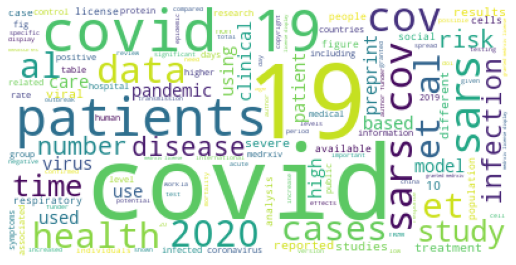

In [11]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(background_color="white")
wordcloud.generate_from_frequencies(frequencies=wc)

plt.figure(figsize=(9,5))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("results/wordcloud.pdf")
plt.show()

# Combining questions with LDA

In [150]:
no_features = 10000

q_vectorizer = CountVectorizer(min_df=2, max_features=no_features, stop_words='english', ngram_range=[1, 2])
qtf = q_vectorizer.fit_transform(most_frequent.question)

ldaq = LatentDirichletAllocation(n_components=20)
ldaq.fit(qtf)

LatentDirichletAllocation(n_components=20)

In [151]:
probs = ldaq.transform(qtf)

In [152]:
probs

array([[0.0125    , 0.0125    , 0.27489119, ..., 0.0125    , 0.0125    ,
        0.0125    ],
       [0.0125    , 0.0125    , 0.0125    , ..., 0.0125    , 0.0125    ,
        0.0125    ],
       [0.0125    , 0.0125    , 0.0125    , ..., 0.0125    , 0.0125    ,
        0.0125    ],
       ...,
       [0.01      , 0.01      , 0.01      , ..., 0.01      , 0.01      ,
        0.01      ],
       [0.0125    , 0.0125    , 0.0125    , ..., 0.0125    , 0.0125    ,
        0.0125    ],
       [0.01666667, 0.01666667, 0.01666667, ..., 0.01666667, 0.01666667,
        0.01666667]])

In [194]:
feature_names = q_vectorizer.get_feature_names()

for topic_idx, topic in enumerate(ldaq.components_):
    print(" ".join([feature_names[i].replace(" ", "_") for i in topic.argsort()[:-6:-1]]))

function pcr virus mers sars
purpose covid prevalence cause sensitivity
treatment vaccine sars cov2 sars_cov2
role health hcq care study
important role viral replication il
normal range normal_range sars wuhan
risk factor risk_factor remdesivir icu
covid age average use ppe
pandemic period impact sars incubation
rate covid ct mechanism rate_covid
does long long_does coronavirus mortality
covid 19 covid_19 did pandemic
scale temperature rna relationship social
sars does long test long_does
used protein spike number coronavirus
covid clinical epidemic pandemic important
difference network vitamin target rbd
model purpose covid crisis disease
definition effect necessary air pollution
sars cov sars_cov role ace2


In [193]:
pd.set_option('display.max_colwidth', 100)
rel = probs * np.tile(most_frequent.counts.to_numpy().reshape(-1, 1), 20)
most_frequent.iloc[rel.argmax(axis=0)] 

question  counts
24                                what is rt pcr     475
7                what is the prevalence of covid    1103
0                what is the treatment for covid    3214
41   what is the clinical manifestation of covid     356
86                                  what is il-6     199
98      what is the most common symptom of covid     179
18             what is the risk factor for covid     572
59                      why do people wear masks     267
10       what is the incubation period for covid     942
9            what is the mortality rate of covid     955
14                     what is social distancing     687
1                               what is covid 19    2622
64                 what is the genotype of covid     254
47      how long does it take for sars to spread     317
36         what is the basic reproduction number     379
51          what is the clinical course of covid     305
138                 what is vitamin d deficiency     135
11                         what is the sir model     916
61               what is the definition of covid     262
3                               what is sars cov    1717

In [198]:
for q in most_frequent.iloc[rel.argmax(axis=0)].question.tolist():
    print(q)

what is rt pcr
what is the prevalence of covid
what is the treatment for covid
what is the clinical manifestation of covid
what is il-6
what is the most common symptom of covid
what is the risk factor for covid
why do people wear masks
what is the incubation period for covid
what is the mortality rate of covid
what is social distancing
what is covid 19
what is the genotype of covid
how long does it take for sars to spread
what is the basic reproduction number
what is the clinical course of covid
what is vitamin d deficiency
what is the sir model
what is the definition of covid
what is sars cov
